# Data Preprocessing


## Exploratory Data Analysis

The exploratory data analysis is something that you should do before building your recommender system. It is a good way to understand your data and to get insights about it. The main goal of such a procedure is to get answers to several questions about your data, these answers should be the numerical justification for all your choices in the following steps, in particular for the feature engineering and the model selection.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions.

In [2]:
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")

# This datframe is not loadable because of chinese characters in the csv
# caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv")

# Make pandas display every columns
pd.set_option('display.max_columns', None)

interactions.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


### Questions about the data
- How many unique users and items are there in the data? Results are coherent with the Table 1 of the paper

In [3]:
users_len = interactions["user_id"].nunique()
videos_len = interactions["video_id"].nunique()

print(f"Users len: {users_len}")
print(f"Videos len: {videos_len}")

Users len: 1411
Videos len: 3327


- What are the data types?

In [4]:
print(interactions.dtypes)

user_id             int64
video_id            int64
play_duration       int64
video_duration      int64
time               object
date              float64
timestamp         float64
watch_ratio       float64
dtype: object


To specify what are each column:

| Field Name     | Description                                      | Type     |
|----------------|--------------------------------------------------|----------|
| user_id        | The ID of the user.                              | int64    |
| video_id       | The ID of the viewed video.                      | int64    |
| play_duration  | Time of video viewing of this interaction (ms).  | int64    |
| video_duration | Time of this video (ms).                         | int64    |
| time           | Human-readable date for this interaction.        | str      |
| date           | Date of this interaction.                        | int64    |
| timestamp      | Unix timestamp.                                  | float64  |
| watch_ratio    | The video watching ratio                         | float64  |

- Are there timestamps, and if so, what is their range?

In [5]:
interactions["time"] = pd.to_datetime(interactions["time"])

print(f"Timestamp range: {interactions["time"].min()} to {interactions["time"].max()}")

Timestamp range: 2020-07-04 02:23:26.060000 to 2020-09-05 23:57:23.683000


- How many interactions are there in the data? Per user? Per item?

In [6]:
total_interactions = len(interactions)
print(f"Total interactions number {total_interactions}")

interactions_per_user = interactions.groupby("user_id").size()
print(f"Mean interactions per user: {interactions_per_user.mean()}")

interactions_per_item = interactions.groupby("video_id").size()
print(f"Mean interactions per item: {interactions_per_item.mean()}")

Total interactions number 4676570
Mean interactions per user: 3314.3656980864635
Mean interactions per item: 1405.6417192666065


Both mean interactions per user and per item are very close of the number of user/item: 3314 for 3327 videos and 1406 for 1411 users. This shows the high density of the small_matrix dataset.<br>
Let's try to calculate the **density** of the small_matrix dataset with the following formula:

$$
\text{Density} = \frac{\text{Number of observed user-item interactions}}{\text{Number of unique users} \times \text{Number of unique items}}
$$

In [7]:
interactions_density = total_interactions / (users_len * videos_len)
print(f"small_matrix dataset density: {interactions_density * 100}%")

small_matrix dataset density: 99.62024941648522%


We get exactly the density of small_matrix described by the paper on Table 1.

### Basic Statistics & Distributions


- Watch ratio distribution - we removed high watch ratio to have a better visualization

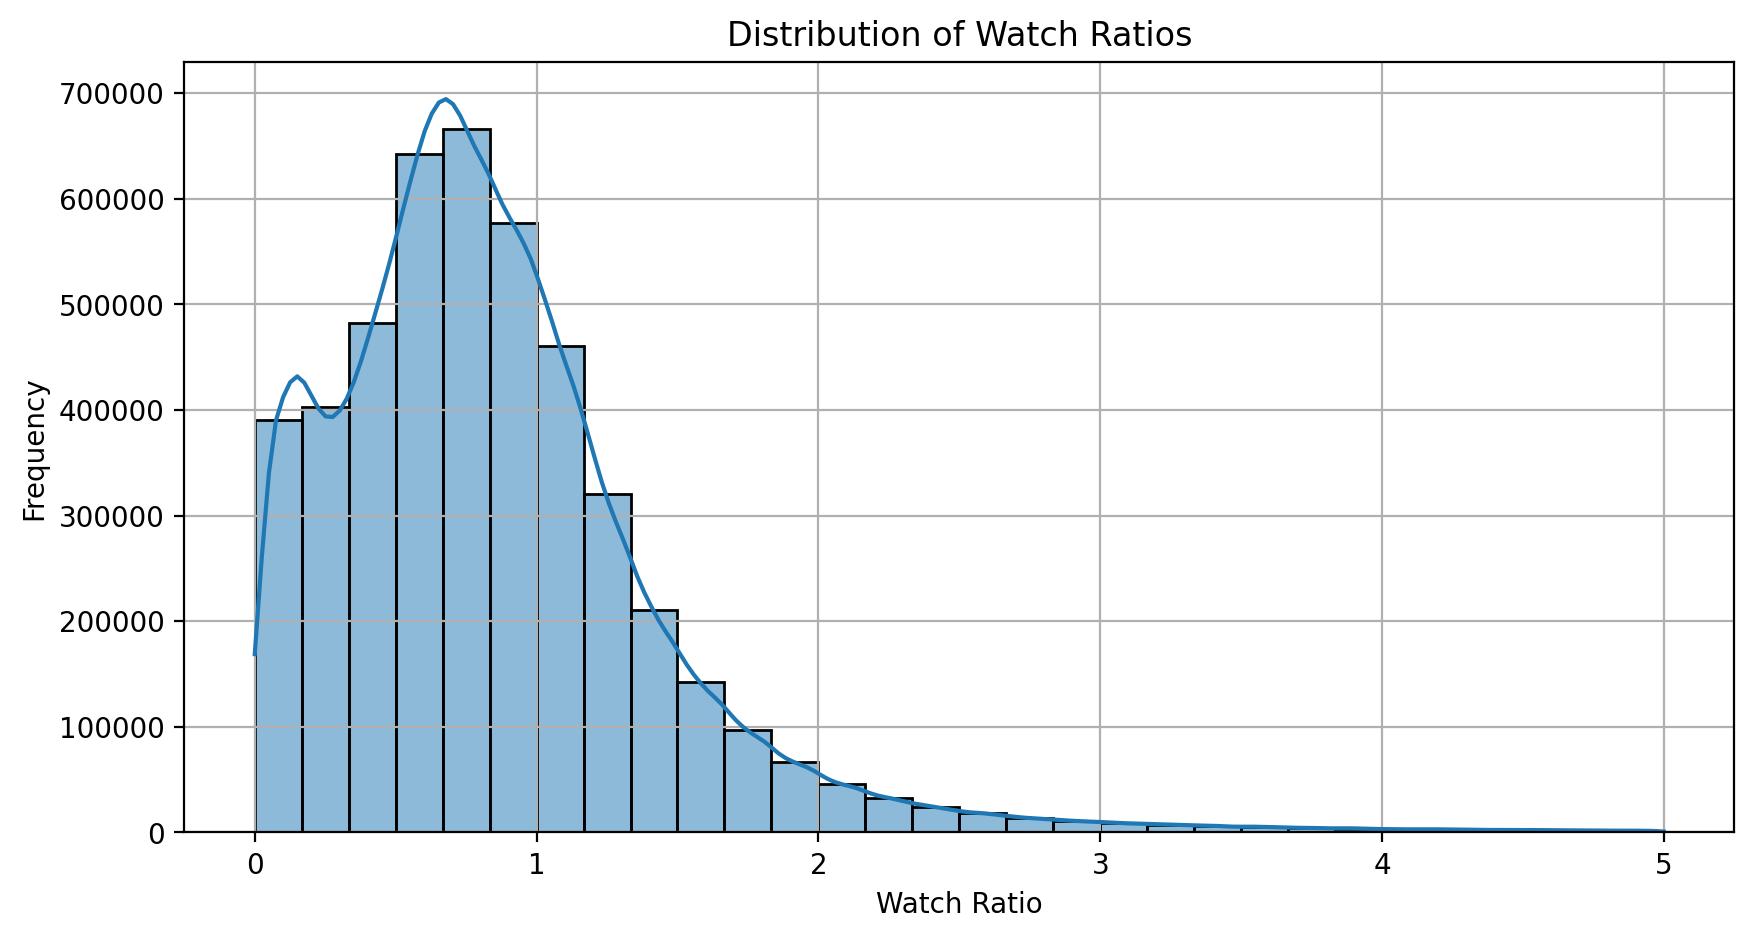

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(interactions[interactions["watch_ratio"] <= 5]["watch_ratio"], bins=30, kde=True)
plt.title("Distribution of Watch Ratios")
plt.xlabel("Watch Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

- Distribution of video duration - we removed high video durations

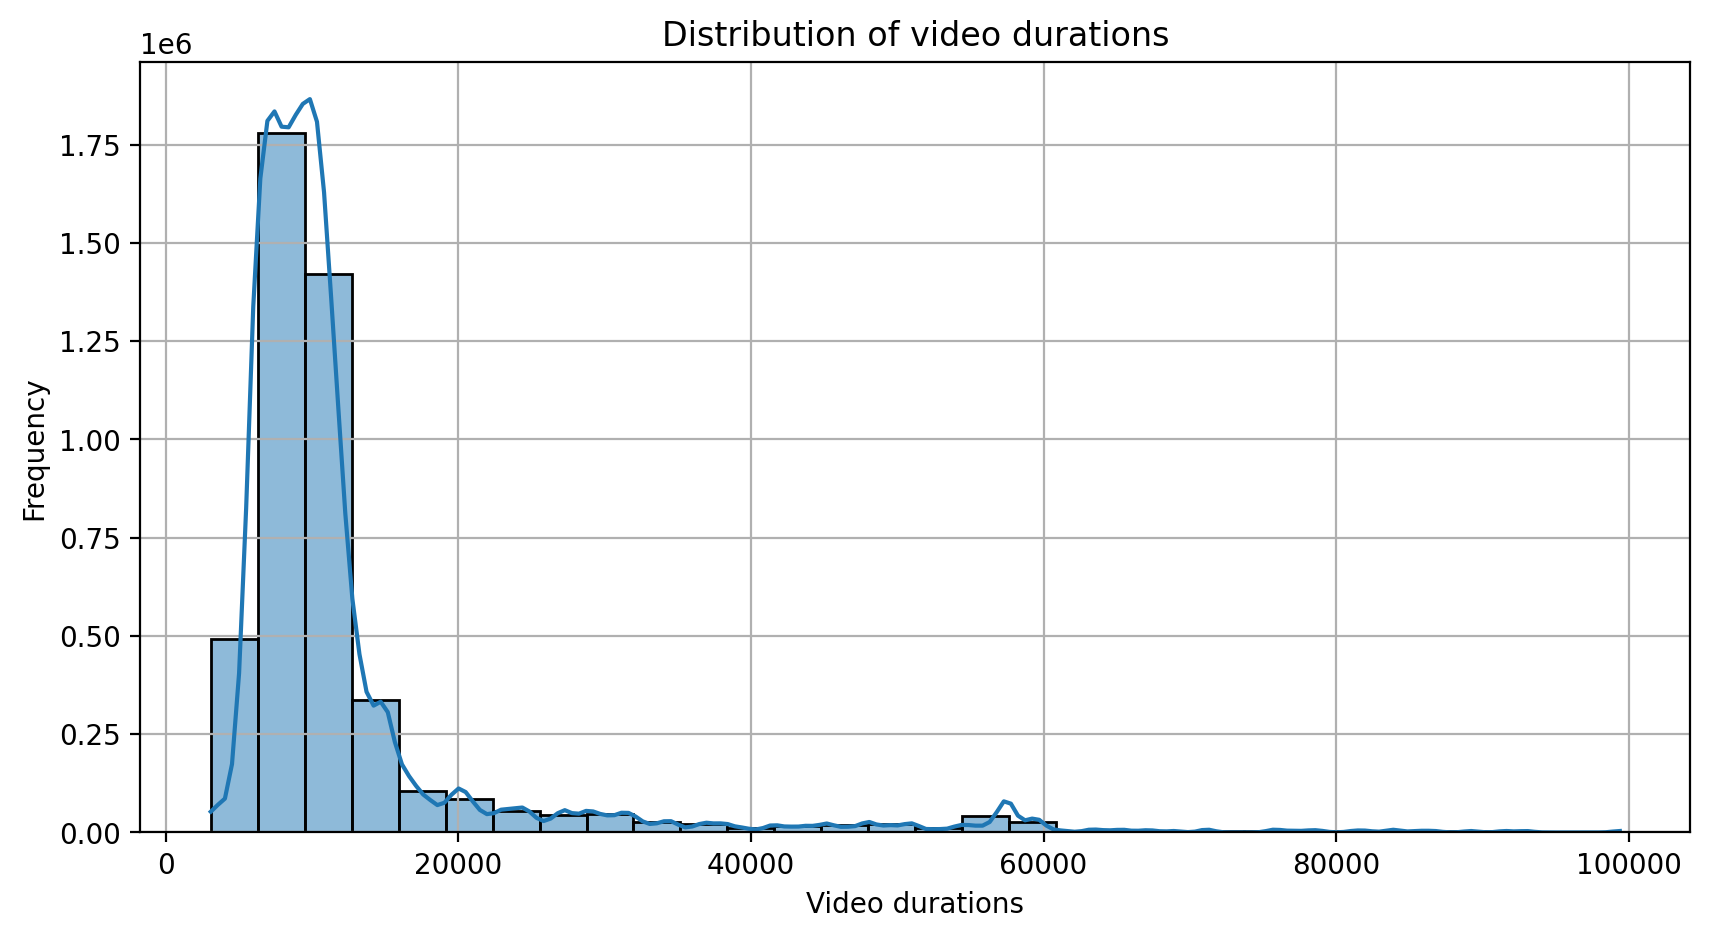

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(interactions[interactions["video_duration"] <= 100000]["video_duration"], bins=30, kde=True)
plt.title("Distribution of video durations")
plt.xlabel("Video durations")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

- Distribution of user total play times

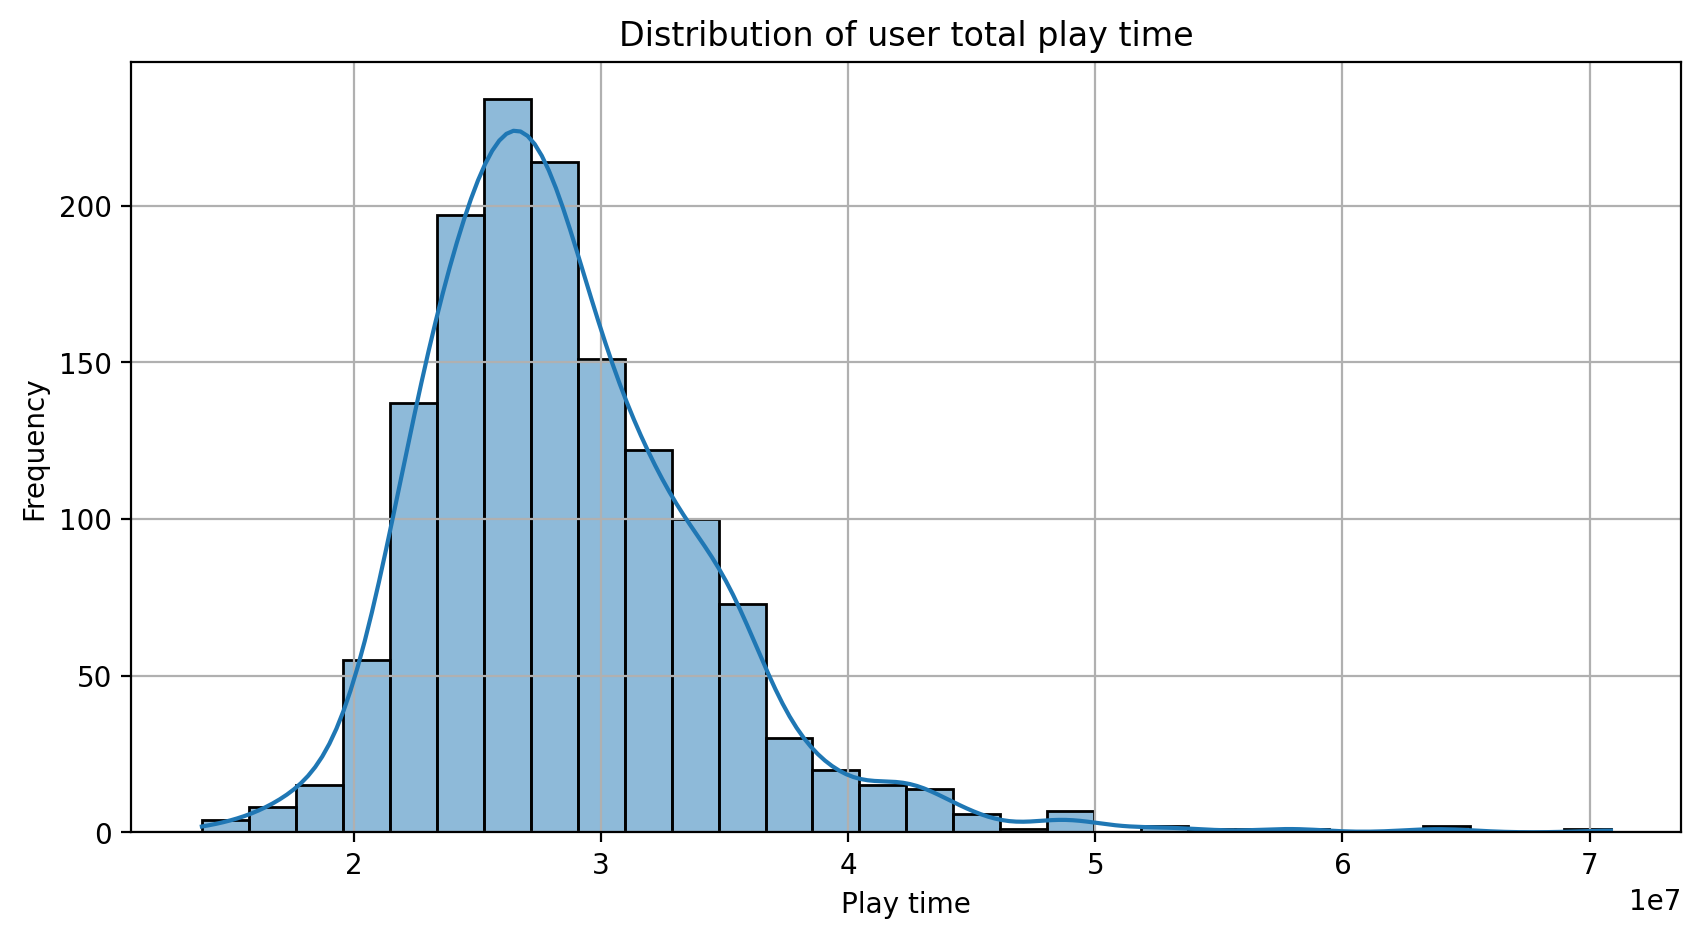

In [22]:
interactions.groupby("user_id").sum("play_duration")["play_duration"]

plt.figure(figsize=(10, 5))
sns.histplot(interactions.groupby("user_id").sum("play_duration")["play_duration"], bins=30, kde=True)
plt.title("Distribution of user total play time")
plt.xlabel("Play time")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

- Average watch ratio per hour of the day

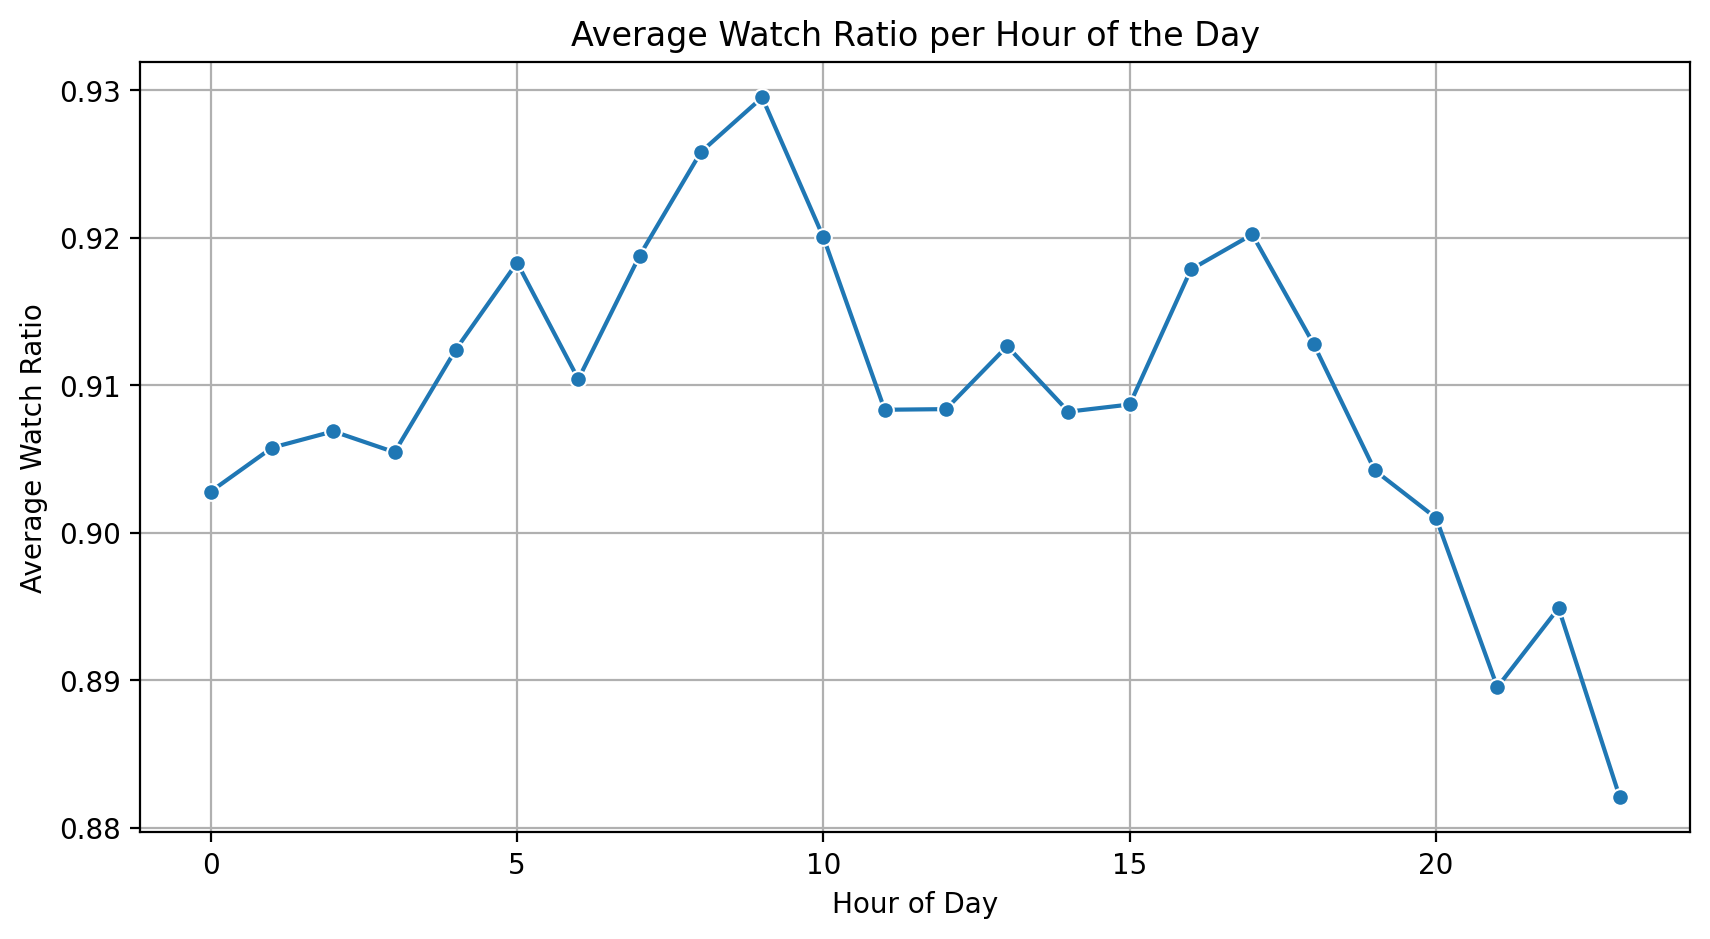

In [23]:
interactions["hour"] = interactions["time"].dt.hour
avg_watch_ratio_per_hour = interactions.groupby("hour")["watch_ratio"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_watch_ratio_per_hour.index, y=avg_watch_ratio_per_hour.values, marker="o")
plt.title("Average Watch Ratio per Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Watch Ratio")
plt.grid(True)
plt.show()

- Correlation between video duration and watch_ratio

Correlation between video duration and watch ratio: -0.1624


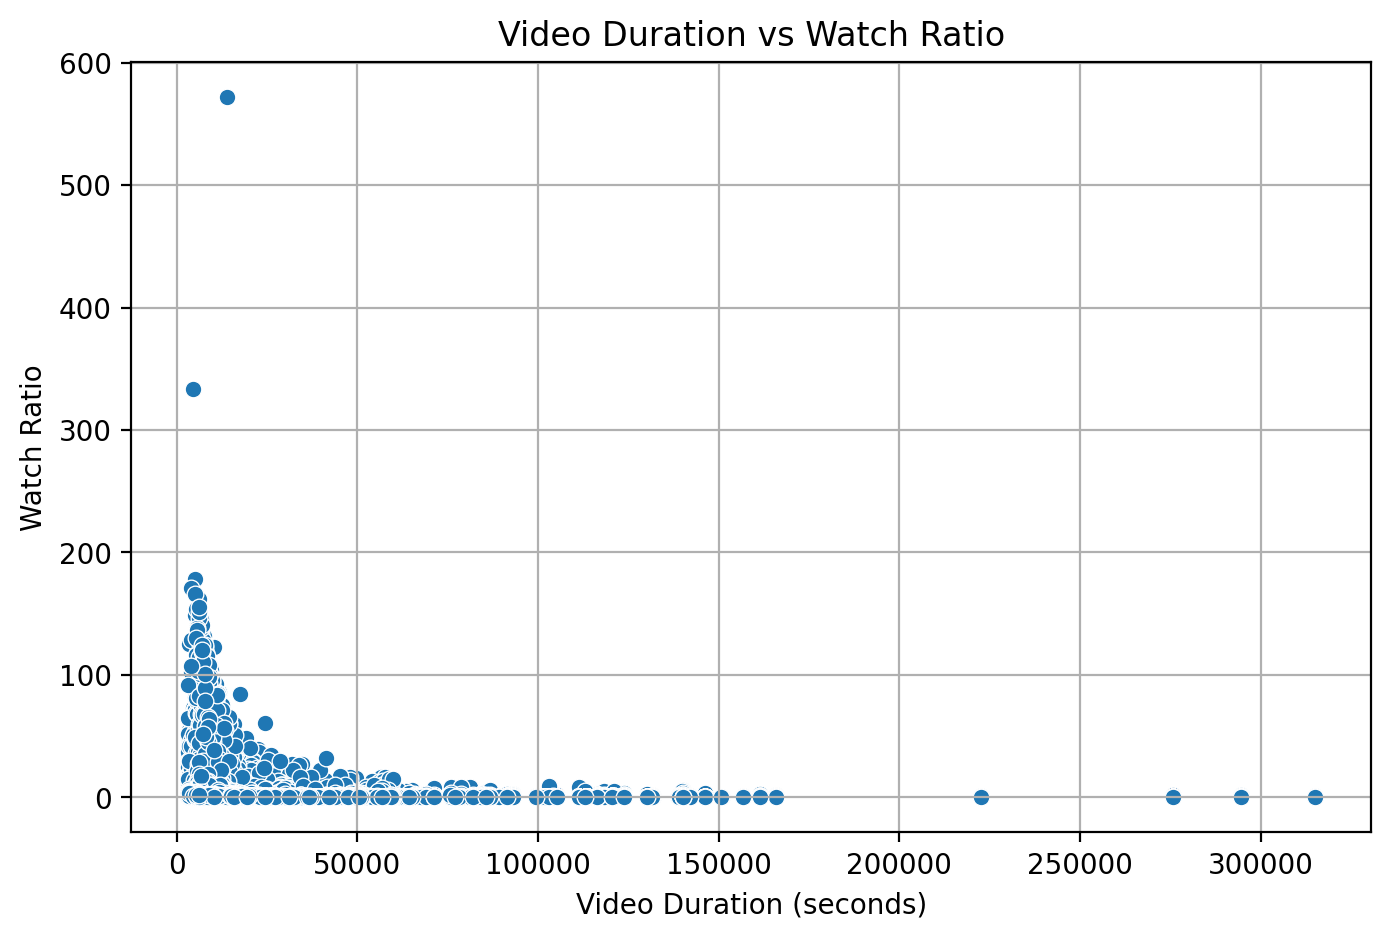

In [24]:
correlation = interactions["video_duration"].corr(interactions["watch_ratio"])
print(f"Correlation between video duration and watch ratio: {correlation:.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(data=interactions, x="video_duration", y="watch_ratio")
plt.title("Video Duration vs Watch Ratio")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Watch Ratio")
plt.grid(True)
plt.show()

- Here we are trying to look at interaction categories based on watched_ratio (based on the paper):
  - \> 2.0 (Strong Positive Interaction)
  - \> 1.0 and < 2.0 (Moderate Positive Interaction)
  - < 1.0 (Weak/Negative Interaction)

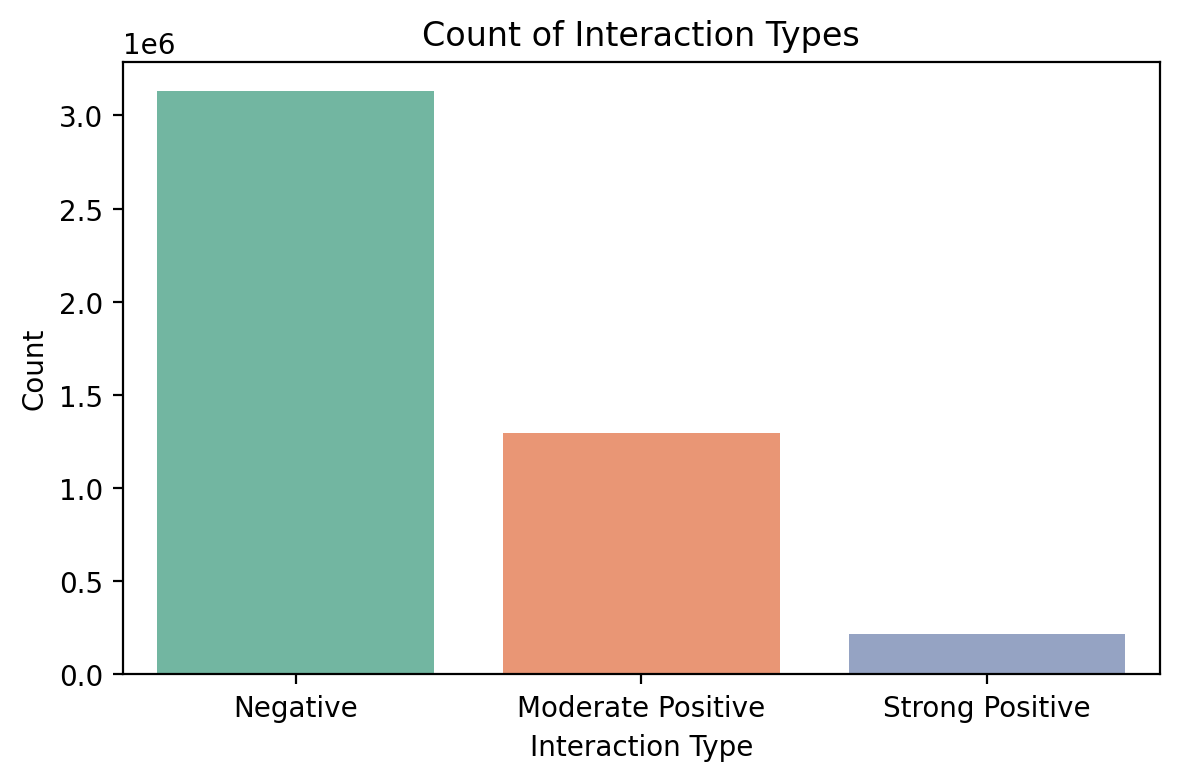

In [26]:
interactions["interaction_type"] = pd.cut(
    interactions["watch_ratio"],
    bins=[0, 1.0, 2.0, float("inf")],
    labels=["Negative", "Moderate Positive", "Strong Positive"]
)

plt.figure(figsize=(6, 4))
sns.countplot(x="interaction_type", hue="interaction_type", data=interactions, palette="Set2", legend=False)
plt.title("Count of Interaction Types")
plt.xlabel("Interaction Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [5]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [59]:
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")

# This doesnt work because there are chinese characters in the csv wtf
# caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv")

pd.set_option('display.max_columns', None)

interactions.head()
# user_features.head() <- ne sert pas pour le content-based filtering
# item_daily_features.head()
item_categories.head()

#small_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
#small_matrix.head()
user_features

,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,friend_user_num_range,register_days,register_days_range,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,0,107,61-90,0,1,17,638,2.0,0,1,6,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,"[1,5)",327,181-365,0,3,25,1021,0.0,0,1,6,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,0,116,91-180,0,6,8,402,0.0,0,0,2,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,0,105,61-90,0,1,8,281,0.0,0,0,34,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,0,225,181-365,0,1,8,316,1.0,0,1,46,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,7171,full_active,0,0,1,52,"(50,100]",1,"[1,10)",0,0,283,181-365,0,3,8,302,1.0,0,1,15,259,1,4,0,1.0,0.0,0.0,0.0,0.0,0.0
7172,7172,full_active,0,0,0,45,"(10,50]",2,"[1,10)",2,"[1,5)",109,91-180,0,3,25,1025,0.0,0,1,35,11,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0
7173,7173,full_active,0,0,0,615,500+,3,"[1,10)",2,"[1,5)",167,91-180,0,6,8,240,1.0,0,0,2,51,2,2,0,1.0,0.0,0.0,0.0,0.0,0.0
7174,7174,full_active,0,0,0,959,500+,0,0,0,0,241,181-365,1,6,25,1029,0.0,0,1,20,107,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
big_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/big_matrix.csv")

big_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [5]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [59]:
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")

# This doesnt work because there are chinese characters in the csv wtf
# caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv")

pd.set_option('display.max_columns', None)

interactions.head()
# user_features.head() <- ne sert pas pour le content-based filtering
# item_daily_features.head()
item_categories.head()

#small_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
#small_matrix.head()
user_features

,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,friend_user_num_range,register_days,register_days_range,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,0,107,61-90,0,1,17,638,2.0,0,1,6,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,"[1,5)",327,181-365,0,3,25,1021,0.0,0,1,6,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,0,116,91-180,0,6,8,402,0.0,0,0,2,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,0,105,61-90,0,1,8,281,0.0,0,0,34,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,0,225,181-365,0,1,8,316,1.0,0,1,46,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,7171,full_active,0,0,1,52,"(50,100]",1,"[1,10)",0,0,283,181-365,0,3,8,302,1.0,0,1,15,259,1,4,0,1.0,0.0,0.0,0.0,0.0,0.0
7172,7172,full_active,0,0,0,45,"(10,50]",2,"[1,10)",2,"[1,5)",109,91-180,0,3,25,1025,0.0,0,1,35,11,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0
7173,7173,full_active,0,0,0,615,500+,3,"[1,10)",2,"[1,5)",167,91-180,0,6,8,240,1.0,0,0,2,51,2,2,0,1.0,0.0,0.0,0.0,0.0,0.0
7174,7174,full_active,0,0,0,959,500+,0,0,0,0,241,181-365,1,6,25,1029,0.0,0,1,20,107,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
big_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/big_matrix.csv")

big_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [5]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [59]:
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")

# This doesnt work because there are chinese characters in the csv wtf
# caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv")

pd.set_option('display.max_columns', None)

interactions.head()
# user_features.head() <- ne sert pas pour le content-based filtering
# item_daily_features.head()
item_categories.head()

#small_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
#small_matrix.head()
user_features

,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,friend_user_num_range,register_days,register_days_range,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,0,107,61-90,0,1,17,638,2.0,0,1,6,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,"[1,5)",327,181-365,0,3,25,1021,0.0,0,1,6,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,0,116,91-180,0,6,8,402,0.0,0,0,2,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,0,105,61-90,0,1,8,281,0.0,0,0,34,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,0,225,181-365,0,1,8,316,1.0,0,1,46,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,7171,full_active,0,0,1,52,"(50,100]",1,"[1,10)",0,0,283,181-365,0,3,8,302,1.0,0,1,15,259,1,4,0,1.0,0.0,0.0,0.0,0.0,0.0
7172,7172,full_active,0,0,0,45,"(10,50]",2,"[1,10)",2,"[1,5)",109,91-180,0,3,25,1025,0.0,0,1,35,11,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0
7173,7173,full_active,0,0,0,615,500+,3,"[1,10)",2,"[1,5)",167,91-180,0,6,8,240,1.0,0,0,2,51,2,2,0,1.0,0.0,0.0,0.0,0.0,0.0
7174,7174,full_active,0,0,0,959,500+,0,0,0,0,241,181-365,1,6,25,1029,0.0,0,1,20,107,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
big_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/big_matrix.csv")

big_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [5]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [59]:
interactions = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
user_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/user_features.csv")
item_daily_features = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_daily_features.csv")
item_categories = pd.read_csv("data_final_project/KuaiRec 2.0/data/item_categories.csv")
social_network = pd.read_csv("data_final_project/KuaiRec 2.0/data/social_network.csv")

# This doesnt work because there are chinese characters in the csv wtf
# caption_category = pd.read_csv("data_final_project/KuaiRec/data/kuairec_caption_category.csv")

pd.set_option('display.max_columns', None)

interactions.head()
# user_features.head() <- ne sert pas pour le content-based filtering
# item_daily_features.head()
item_categories.head()

#small_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/small_matrix.csv")
#small_matrix.head()
user_features

,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,friend_user_num_range,register_days,register_days_range,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,0,107,61-90,0,1,17,638,2.0,0,1,6,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,"[1,5)",327,181-365,0,3,25,1021,0.0,0,1,6,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,0,116,91-180,0,6,8,402,0.0,0,0,2,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,0,105,61-90,0,1,8,281,0.0,0,0,34,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,0,225,181-365,0,1,8,316,1.0,0,1,46,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,7171,full_active,0,0,1,52,"(50,100]",1,"[1,10)",0,0,283,181-365,0,3,8,302,1.0,0,1,15,259,1,4,0,1.0,0.0,0.0,0.0,0.0,0.0
7172,7172,full_active,0,0,0,45,"(10,50]",2,"[1,10)",2,"[1,5)",109,91-180,0,3,25,1025,0.0,0,1,35,11,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0
7173,7173,full_active,0,0,0,615,500+,3,"[1,10)",2,"[1,5)",167,91-180,0,6,8,240,1.0,0,0,2,51,2,2,0,1.0,0.0,0.0,0.0,0.0,0.0
7174,7174,full_active,0,0,0,959,500+,0,0,0,0,241,181-365,1,6,25,1029,0.0,0,1,20,107,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
big_matrix = pd.read_csv("data_final_project/KuaiRec 2.0/data/big_matrix.csv")

big_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


##  Data Quality, Missing Values and Preprocessing

- Checking for missing value in small_matrix and item_daily_features:

For small_matrix, a lot of time/date/timestamps are missing from the dataset, but other categories don't present any missing values. It is not important as we don't use these datas for training

In [8]:
interactions.isnull().sum()

user_id                0
video_id               0
play_duration          0
video_duration         0
time              181992
date              181992
timestamp         181992
watch_ratio            0
dtype: int64

For item_daily_features, we miss some important values of video_duration and video_tag_name.

In [9]:
item_daily_features.isnull().sum()

video_id                        0
date                            0
author_id                       0
video_type                      0
upload_dt                       0
upload_type                     0
visible_status                  0
video_duration              10598
video_width                     0
video_height                    0
music_id                        0
video_tag_id                    0
video_tag_name              32434
show_cnt                        0
show_user_num                   0
play_cnt                        0
play_user_num                   0
play_duration                   0
complete_play_cnt               0
complete_play_user_num          0
valid_play_cnt                  0
valid_play_user_num             0
long_time_play_cnt              0
long_time_play_user_num         0
short_time_play_cnt             0
short_time_play_user_num        0
play_progress                   0
comment_stay_duration           0
like_cnt                        0
like_user_num 

 So, we remove all the data that has no video_duration nor video_tag_name. Other missing values are not relevant in our training.

In [11]:
item_daily_features = item_daily_features.dropna(subset=['video_tag_name', 'video_duration'])
item_daily_features.isnull().sum()

video_id                        0
date                            0
author_id                       0
video_type                      0
upload_dt                       0
upload_type                     0
visible_status                  0
video_duration                  0
video_width                     0
video_height                    0
music_id                        0
video_tag_id                    0
video_tag_name                  0
show_cnt                        0
show_user_num                   0
play_cnt                        0
play_user_num                   0
play_duration                   0
complete_play_cnt               0
complete_play_user_num          0
valid_play_cnt                  0
valid_play_user_num             0
long_time_play_cnt              0
long_time_play_user_num         0
short_time_play_cnt             0
short_time_play_user_num        0
play_progress                   0
comment_stay_duration           0
like_cnt                        0
like_user_num 

- Checking for duplicates: first checking if there are two similar lines, then for duplicates based on a combination of user_id and video_id. In both cases, there are no duplicates.

In [16]:
print(interactions.duplicated().sum())
print(interactions[interactions.duplicated(subset=['user_id', 'video_id'], keep=False)])

0
Empty DataFrame
Columns: [user_id, video_id, play_duration, video_duration, time, date, timestamp, watch_ratio]
Index: []


- Checking for negative or zero durations and negative timestamps: no found.

In [17]:
print((interactions["play_duration"] < 0).sum() + (interactions["video_duration"] <= 0).sum())
print((interactions["timestamp"] < 0).sum())

0
0
